# Sampling from a GP

## Preliminary steps

### Loading necessary packages

In [1]:
using Plots
using AugmentedGaussianProcesses
using Distributions
using LinearAlgebra

### Generating some random data

In [2]:
kernel = SqExponentialKernel()
x = range(0, 10; length=50)
K = kernelmatrix(kernel, x)
f = rand(MvNormal(K + 1e-8I)) # Sample a random GP
y = rand.(Bernoulli.(AGP.logistic.(f)))
y_sign = Int.(sign.(y .- 0.5))

50-element Vector{Int64}:
 -1
  1
  1
  1
  1
 -1
 -1
 -1
 -1
 -1
  ⋮
  1
  1
  1
 -1
 -1
 -1
 -1
 -1
  1

### We create a function to visualize the data

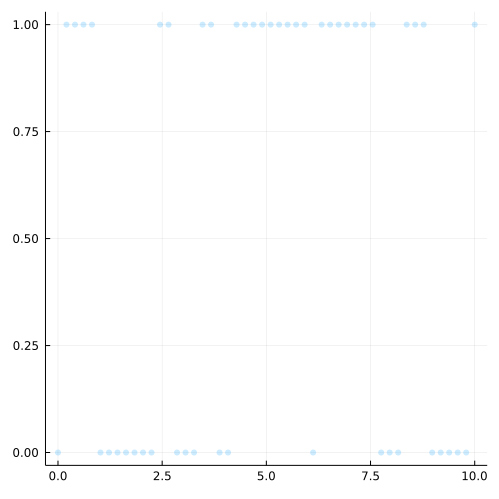

In [3]:
function plot_data(x, y; size=(300, 500))
    return Plots.scatter(x, y; alpha=0.2, markerstrokewidth=0.0, lab="", size=size)
end
plot_data(x, y; size=(500, 500))

### Run the variational gaussian process approximation

In [4]:
@info "Running full model"
mfull = VGP(x, y_sign, kernel, LogisticLikelihood(), AnalyticVI(); optimiser=false)
@time train!(mfull, 5)

[ Info: Running full model
  0.800042 seconds (1.86 M allocations: 98.391 MiB, 99.61% compilation time)


(Variational Gaussian Process with a BernoulliLikelihood{GPLikelihoods.LogisticLink}(GPLikelihoods.LogisticLink(LogExpFunctions.logistic)) infered by Analytic Variational Inference , (local_vars = (c = [0.7987826909927372, 0.7391749990379961, 0.6739749938007737, 0.6249205046996366, 0.624072796520079, 0.6871843087758596, 0.7936991571113472, 0.906542687927407, 0.9953163715240657, 1.0431275112819935  …  0.6051712455613051, 0.6069743003416113, 0.6423393616897126, 0.6957146071792305, 0.7523701240786799, 0.8012445715413459, 0.836081060265695, 0.8555811129643905, 0.8633102025408995, 0.8662066602653798], θ = [0.23750392799775039, 0.2392064465606116, 0.24094759613394373, 0.24216970092587262, 0.24219013511144355, 0.24060542081282912, 0.23765309217524389, 0.23417779650688073, 0.23121967248555175, 0.2295529625731908  …  0.2426396060443819, 0.2425972408353551, 0.24174461999097677, 0.24038155853658366, 0.23883845480913934, 0.23743142960366403, 0.23638760641336273, 0.23578897794970882, 0.235548920479

### We can also create a sampling based model

In [5]:
@info "Sampling from model"
mmcmc = MCGP(x, y, kernel, LogisticLikelihood(), GibbsSampling(); optimiser=false)
m = mmcmc
@time samples = sample(mmcmc, 1000)

[ Info: Sampling from model
Sampling with Gibbs Sampler   0%|                       |  ETA: N/A
Sampling with Gibbs Sampler   0%|▏                      |  ETA: 0:04:03
Sampling with Gibbs Sampler   1%|▎                      |  ETA: 0:02:04
Sampling with Gibbs Sampler   1%|▍                      |  ETA: 0:01:22
Sampling with Gibbs Sampler   2%|▍                      |  ETA: 0:01:02
Sampling with Gibbs Sampler   2%|▌                      |  ETA: 0:00:49
Sampling with Gibbs Sampler   3%|▋                      |  ETA: 0:00:41
Sampling with Gibbs Sampler   3%|▊                      |  ETA: 0:00:35
Sampling with Gibbs Sampler   4%|▉                      |  ETA: 0:00:30
Sampling with Gibbs Sampler   4%|█                      |  ETA: 0:00:27
Sampling with Gibbs Sampler   5%|█                      |  ETA: 0:00:24
Sampling with Gibbs Sampler   5%|█▏                     |  ETA: 0:00:22
Sampling with Gibbs Sampler   5%|█▎                     |  ETA: 0:00:20
Sampling with Gibbs Sampler   6%|█▍     

1000-element Vector{Vector{Vector{Float64}}}:
 [[0.2947021637090833, 0.368282488195555, 0.3043120520761244, 0.1907594317484543, 0.010445442849472408, -0.25689712461279784, -0.4835380466113927, -0.635831383988908, -0.6730658054763973, -0.5417722533714695  …  1.0203339459796155, 0.9046436527169119, 0.6417728346983556, 0.33443502697061117, 0.05206649158130394, -0.16476966173829344, -0.289171321273592, -0.3470452883588224, -0.3383383544085266, -0.3713866045223946]]
 [[0.8161919970846345, 0.5353871532095413, 0.25668731304418, 0.025191164714887332, -0.15112833042658913, -0.3063611612374633, -0.412712202971549, -0.483541350475971, -0.5592308272560341, -0.5759987435209526  …  -0.2658642136053393, -0.3440853074627741, -0.37103601243986645, -0.4141300502087908, -0.4268083625867616, -0.4657325418545149, -0.4798039687960968, -0.49101110547709215, -0.528711281262956, -0.5917880602954303]]
 [[-0.04890395956098342, -0.14379796248143012, -0.2665060035286029, -0.4129792328811661, -0.5633037193345942, -

### We can now visualize the results of both models

### We first plot the latent function f (truth, the VI estimate, the samples)

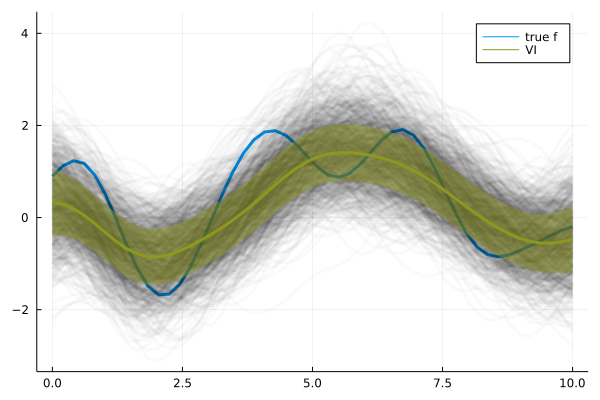

In [6]:
p1 = plot(x, f; label="true f")
plot!(x, samples; label="", color=:black, alpha=0.02, lab="")
plot!(x, mean(mfull[1]); ribbon=sqrt.(var(mfull[1])), label="VI")

### And we can also plot the predictions vs the data

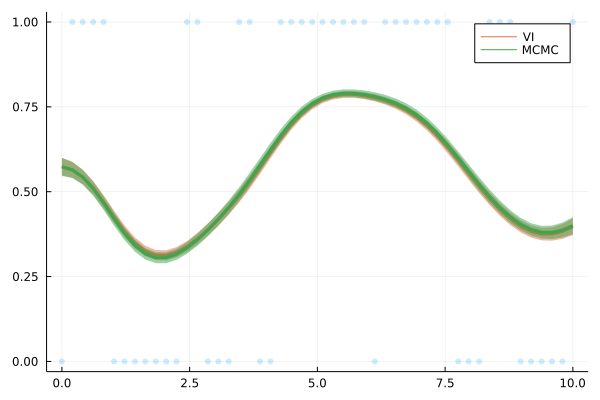

In [7]:
p2 = plot_data(x, y; size=(600, 400))
μ_vi, σ_vi = proba_y(mfull, x)
plot!(x, μ_vi; ribbon=σ_vi, label="VI")
μ_mcmc, σ_mcmc = proba_y(mmcmc, x)
plot!(x, μ_mcmc; ribbon=σ_mcmc, label="MCMC")

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*